## Figures for analysis of the SCLC dataset
This notebook reproduces Figures 1A-C, 1G-H, 2A-B, 3C, 3G, 4F, S1G, S2B, S3A, S3C-E

In [1]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
import scanpy as sc
from copy import deepcopy
import pickle
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from scipy.stats import zscore


In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_style('ticks')

<h3> Load data </h3>

In [5]:
out_dir = '../out.SCLC.060121/'

In [6]:
### Can be downloaded at https://data.humantumoratlas.org/
adata = sc.read_h5ad(out_dir + 'adata.SCLC.010920.h5ad')

In [7]:
### Can be downloaded at https://data.humantumoratlas.org/
adata_RU1215 = sc.read_h5ad(out_dir + 'adata.SCLC.RU1215.010920.h5ad')

### Figure 1A

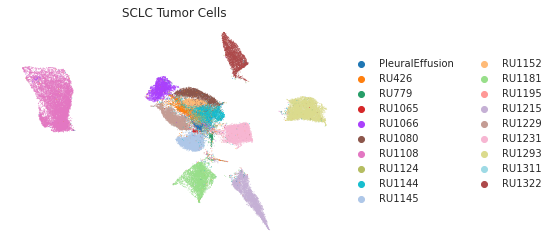

In [8]:
### FIGURE 1A
sc.pl.umap(adata, 
           color=['patient'],
    frameon=False,  use_raw=False,
    sort_order=False, 
    ncols=1, title ='SCLC Tumor Cells',
)

### Figure 1B-C

In [9]:
adata.obs.loc[:,'treatment_categorized2'] = adata.obs.loc[:,'treatment_categorized'].str.replace('TMZ.*','Later-line therapy')
adata.obs.loc[:,'treatment_categorized2'] = adata.obs.loc[:,'treatment_categorized2'].astype('category')

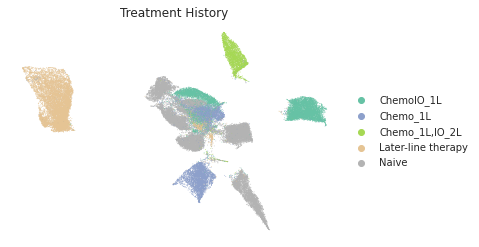

In [10]:
### FIGURE 1B
sc.pl.umap(adata, 
           color=['treatment_categorized2'],
    palette= 'Set2',
    frameon=False,  use_raw=False,
    sort_order=False, 
    ncols=1, title ='Treatment History',
)

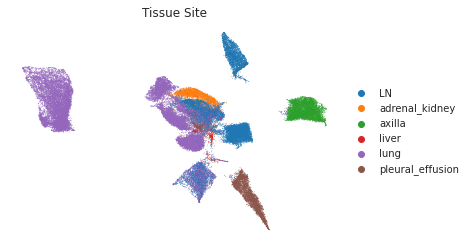

In [11]:
### FIGURE 1C
sc.pl.umap(adata, 
           color=['tissue'],
    frameon=False,  use_raw=False,
    sort_order=False, 
    ncols=1, title ='Tissue Site'
)

### Figure 1G

In [12]:
adata.obs.SCLC_subtype_plus_TP53_RB1_wt = adata.obs.SCLC_subtype_plus_TP53_RB1_wt.str.replace(' ','\n')


... storing 'SCLC_subtype_plus_TP53_RB1_wt' as categorical


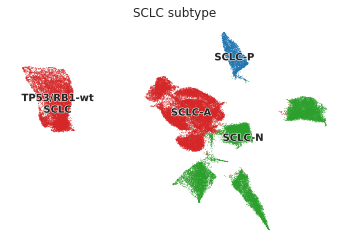

In [13]:
sc.pl.umap(adata, 
           color=['SCLC_subtype_plus_TP53_RB1_wt'],
    palette= ['tab:red','tab:green','tab:blue','tab:red'],
    frameon=False,  use_raw=False,
    sort_order=False, legend_loc='on data', legend_fontoutline=True,
    ncols=1, title ='SCLC subtype',
)

### Figure 1H

In [14]:
adata.obs.loc[:,'NEUROD genes'] = np.sum(adata.layers['imputed_normalized'][:, adata.var.index.str.contains('NEUROD')], axis=1)

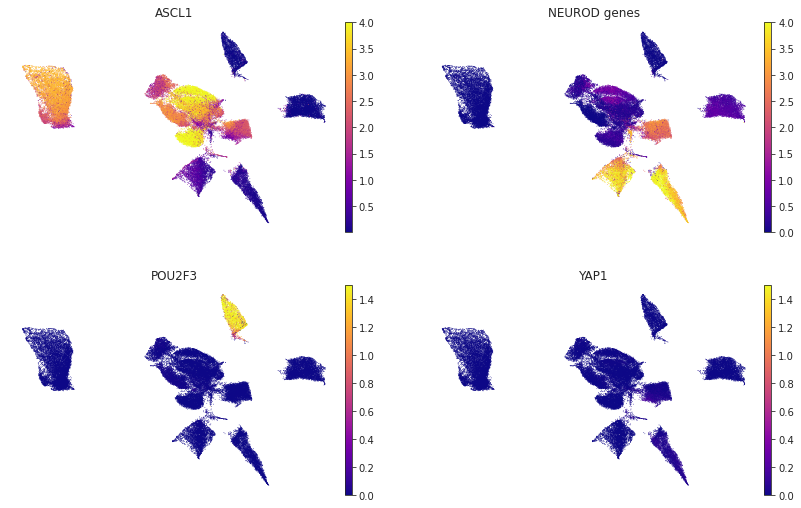

In [15]:
sc.pl.umap(adata, 
           color=['ASCL1','NEUROD genes','POU2F3','YAP1'],
           color_map = 'plasma',
    frameon=False,  use_raw=False,
    sort_order=False, layer = 'imputed_normalized',
    ncols=2, vmax= [4,4,1.5,1.5]
)

### Figure 2A

In [16]:
ct_dict = {'SCLC-A TFs': ['ASCL1','TFF3','SOX4','KLF6'],
           'SCLC-N TFs': ['NEUROD1','NEUROD4'],
           'SCLC-P TFs': ['POU2F3','ASCL2','SOX9','YBX3','HOXC10'],
           'SCLC-Y TFs': ['YAP1'],
           'MYC\nFamily': ['MYC','MYCN','MYCL'],
           'Notch\nSignaling': ['NOTCH1','HES6','HES1'],
           'Neuronal\nDifferentiation': ['TCF4', 'MARCKS', 'ADCYAP1'],
           'Axonogenesis': ['NRXN1','SEMA6A','EFNB1','EPHB2','NRP2','OLFM2'],
           'Neurotransmitter': ['SSTR2','SST'],
           'Endodermal\nDifferentiation': ['SOX7', 'INHBA'],
           'Hypoxia\nAngiogenesis': ['HIF1A', 'VEGFA', 'FOXO3'],
           'EMT\nMetastasis': ['VIM','COL1A2','TWIST1', 'ZEB1', 'MMP2', 'MMP14'],
           'TGFB\nSignaling': ['TGFB1', 'TGFBR1', 'TGFBR3'],
           'BMP\nSignaling': ['BMP2', 'BMP7', 'BMPR1A', 'BMPR2'],
           'STAT\nSignaling': ['STAT3', 'IL6R', 'IL11RA', 'IL13RA1'],
           'TNFA/NFKB\nSignaling': ['TNF', 'PHLDA1', 'SMAD3', 'SPHK1', 'NFAT5']}

In [17]:
import itertools
gene_list = list(itertools.chain.from_iterable(list(ct_dict.values())))


In [18]:
ct_pos = [[i for i,j in enumerate(gene_list) if j in val] for val in ct_dict.values()]
ct_pos = [(i[0],i[0]) if len(i)==1 else (i[0],i[-1]) for i in ct_pos]

In [19]:
adata.obs.SCLC_subtype = adata.obs.SCLC_subtype.cat.reorder_categories(['SCLC-P','SCLC-N','SCLC-A'])

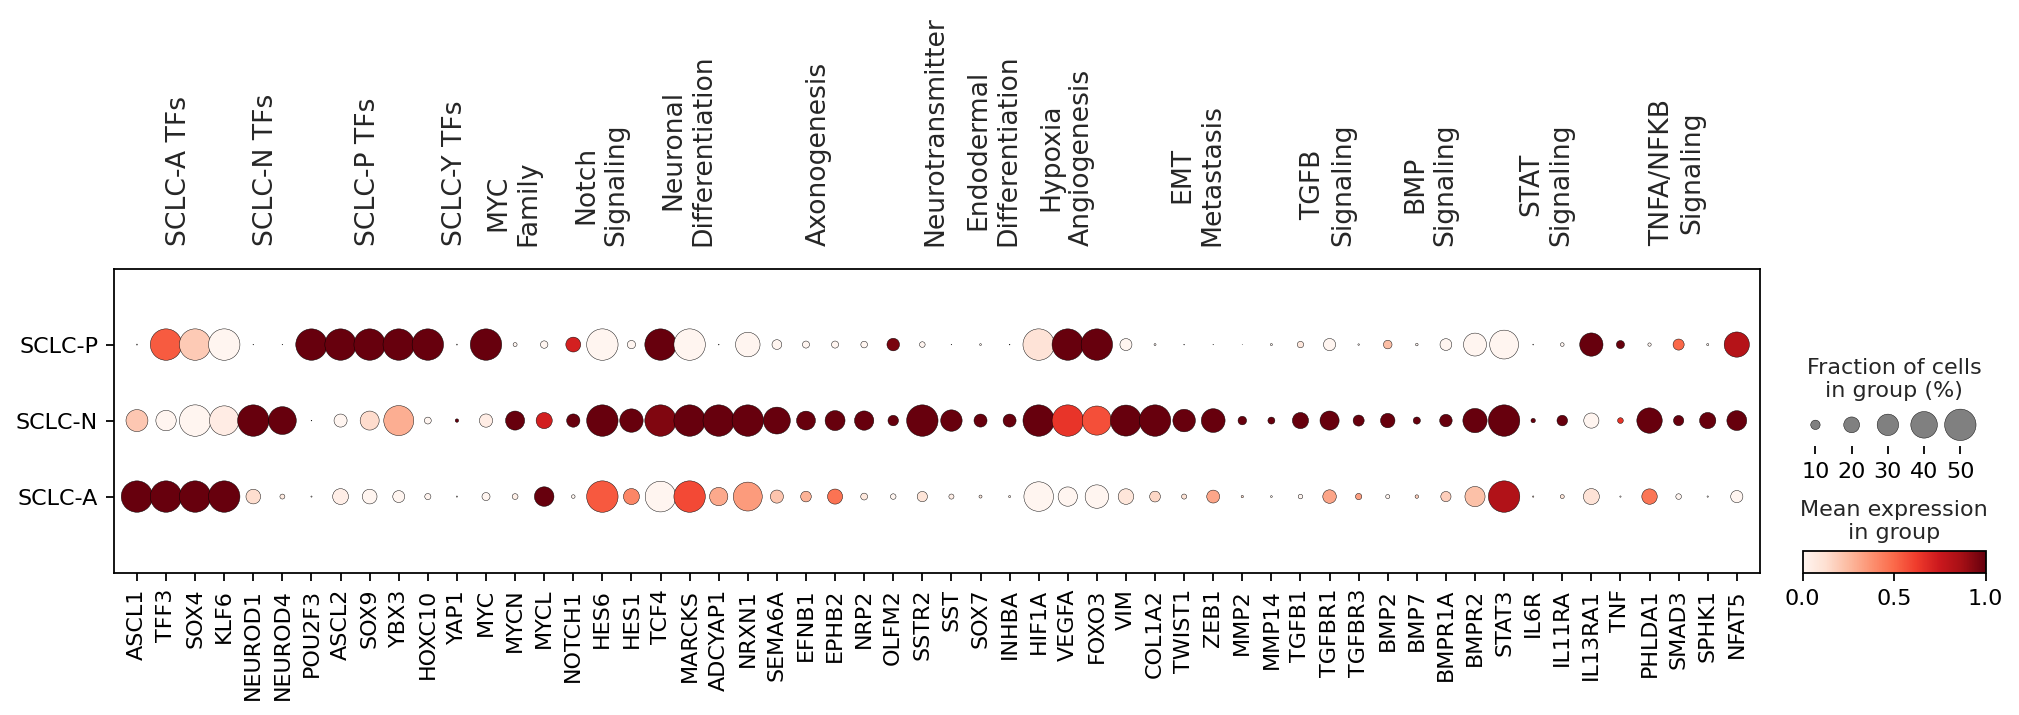

In [20]:
sc.set_figure_params(fontsize=12)
ax = sc.pl.dotplot(adata[adata.obs.SCLC_subtype_plus_TP53_RB1_wt!='TP53/RB1-wt\nSCLC',:],
                   gene_list, groupby='SCLC_subtype', dendrogram=False,
                   var_group_positions=ct_pos,use_raw = False,
                   var_group_labels=list(ct_dict.keys()), 
                   figsize=(15,2.5), dot_max = 0.5, #0.6,
                   standard_scale = 'var') #, var_group_rotation=0)


<h3> Figure 2B </h3>

In [21]:
def scale_01(df):
    tmp = df.values
    row_index = df.index
    col_index = df.columns
    row_min = tmp.min(axis=1)
    tmp =  tmp - row_min[:,None]
    row_max = tmp.max(axis=1)
    scaled = pd.DataFrame(tmp / row_max[:, None], index = row_index, columns = col_index) 
    return scaled

In [22]:
from pygam import LinearGAM, s, f
from scipy.stats import mode

def GetGamTrends(pdt_cells, genes, data, n_splines = 8):

    win = 30

    min_val = 1e9
    gamx, gamy, gam_ci = {},{},{}
    for g in genes:
        X = pdt_cells.values 
        y = np.array(data.loc[pdt_cells.index,g])
        gam = LinearGAM(s(0, n_splines=n_splines,spline_order=3))
        gam.fit(X, y)

        gam.gridsearch(X, y, progress=False)
        XX = gam.generate_X_grid(term=0)
        m = X.min()
        M = X.max()
        XX = np.linspace(m - .10, M + .10, 500)

        YY = gam.predict(XX)
        gamx[g] = XX
        gamy[g] = YY
        if min_val > YY.min():
            min_val = YY.min()
            
        gam_ci[g] = gam.prediction_intervals(XX, width=.95)
        
    return gamx, gamy, gam_ci    

In [23]:
filter_genes = adata.var_names.str.contains(
    "^MT-|^MTMR|^MTND|NEAT1|TMSB4X|TMSB10|^RPS|^RPL|^RP11|^MRP|^FAU$|UBA52|MALAT|^IGH|^IGK|^IGL[CV]|^HBA|^HBB")
filter_cells = adata.obs.SCLC_subtype_plus_TP53_RB1_wt.isin(['TP53/RB1-wt SCLC','SCLC-P'])

In [24]:
pval_df = adata.obs.loc[~filter_cells,['pval_SCLC-A','pval_SCLC-N']]

In [17]:
pval_df = pval_df.div(pval_df.sum(axis=1), axis=0)

In [18]:
ind = np.argsort(pval_df.loc[:,'pval_SCLC-A'])

In [19]:
imp_merge = pd.DataFrame(adata.layers['imputed_normalized'],
                         index=adata.obs.index,
                         columns = adata.var_names)

In [20]:
imp_merge2 = imp_merge.loc[~filter_cells,~filter_genes]

In [24]:
scaled01_imp_df = scale_01(imp_merge2.iloc[ind,:].T).T

In [25]:
tmp = scaled01_imp_df.loc[:,['NEUROD1','NEUROD2','NEUROD4','NEUROD6']].sum(axis=1)
tmp = tmp - tmp.min()
scaled01_imp_df.loc[:,'NEUROD genes'] = tmp / tmp.max()

In [26]:
pval_SCLCtype = pval_df.loc[:,'pval_SCLC-A'].iloc[ind]

In [27]:
pal_GR = sns.diverging_palette(160, 5, n=501, center="light")
bin_SCLCtype = pd.cut(pval_SCLCtype, bins=500)
lut = dict(zip(sorted(list(set(bin_SCLCtype))), pal_GR))
row_colors2 = [lut[i] for i in bin_SCLCtype]


In [38]:
pdt = pval_df.loc[:,'pval_SCLC-A'].iloc[ind]

In [39]:
pdt2 = pd.Series(np.arange(len(pdt)), index = pdt.sort_values().index)

In [40]:
gamx, gamy, gam_ci = GetGamTrends(pdt2, ['ASCL1','NEUROD genes'], scaled01_imp_df)

In [41]:
sns.set_style('ticks')

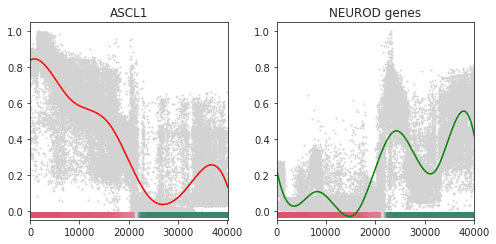

In [95]:
fig, axes = plt.subplots(1,2,figsize=(7,3.5))


for g, col, ax in zip(['ASCL1','NEUROD genes'], ['r','g'], np.ravel(axes)):

    ax.scatter(pdt2.loc[::-1], scaled01_imp_df[g], s=1, c = 'lightgray')
    ax.plot(gamx[g][::-1], gamy[g], c= col)
    ax.set_xlim([min(pdt2),max(pdt2)])
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(g)
    
    scatter = ax.scatter(x=pdt2[::-1], y=[-0.02] * len(pdt2),
                             c = row_colors2, cmap = pal_GR, s=25, marker='s') #label = use_samples[i])

plt.tight_layout()


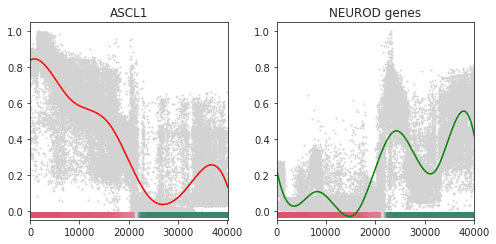

In [42]:
fig, axes = plt.subplots(1,2,figsize=(7,3.5))


for g, col, ax in zip(['ASCL1','NEUROD genes'], ['r','g'], np.ravel(axes)):

    ax.scatter(pdt2.loc[::-1], scaled01_imp_df[g], s=1, c = 'lightgray')
    ax.plot(gamx[g][::-1], gamy[g], c= col)
    ax.set_xlim([min(pdt2),max(pdt2)])
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(g)
    
    scatter = ax.scatter(x=pdt2[::-1], y=[-0.02] * len(pdt2),
                             c = row_colors2, cmap = pal_GR, s=25, marker='s') #label = use_samples[i])

plt.tight_layout()

plt.savefig('/data/peer/chanj3/HTA.SCLC.010920/out.SCLC.SCLCtype_deg.SCLC_only.010920/figures/1d_plot.SCLC-A_vs_SCLC-N.canonical_genes.publication.png',
           bbox_inches='tight', dpi=300)

In [32]:
gsets_interest = ['AXONOGENESIS','NEURON_DIFFERENTIATION','NEUROPEPTIDE_RECEPTOR','EMT']

gset_dict = {}
for i in gsets_interest:
    gset_dict[i] = adata.var_names[adata.var.loc[:,i]]

In [33]:
gset_df = pd.DataFrame(index = scaled01_imp_df.index)

In [34]:
for gset in gset_dict.keys():
    tmp = scaled01_imp_df.loc[:,gset_dict[gset]].sum(axis=1)
    tmp = tmp - tmp.min()
    gset_df.loc[:,gset] = tmp / tmp.max()

In [35]:
gamx, gamy, gam_ci = GetGamTrends(pdt2, list(gset_df.keys()), gset_df, n_splines = 6)

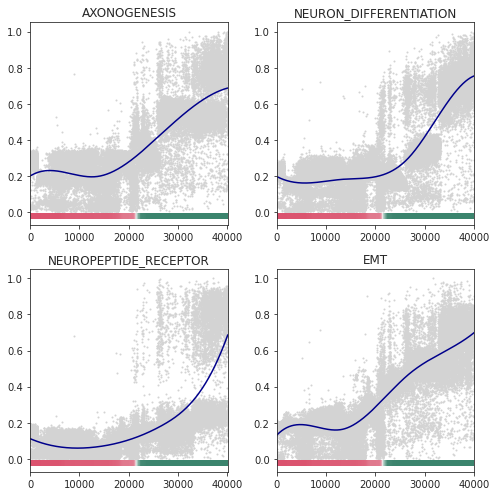

In [36]:
fig, axes = plt.subplots(2,2,figsize=(7,7))

for gset, ax in zip(gsets_interest, np.ravel(axes)):

    ax.scatter(pdt2.loc[::-1], gset_df[gset], s=1, c = 'lightgray')
    ax.plot(gamx['EMT'][::-1], gamy[gset], c='darkblue')
    ax.set_xlim([min(pdt2),max(pdt2)])
    ax.set_title(gset)
    
    scatter = ax.scatter(x=pdt2.loc[::-1], y=[-0.02] * len(pdt2),
                             c = row_colors2, cmap = pal_GR, s=25, marker='s') #label = use_samples[i])

plt.tight_layout()

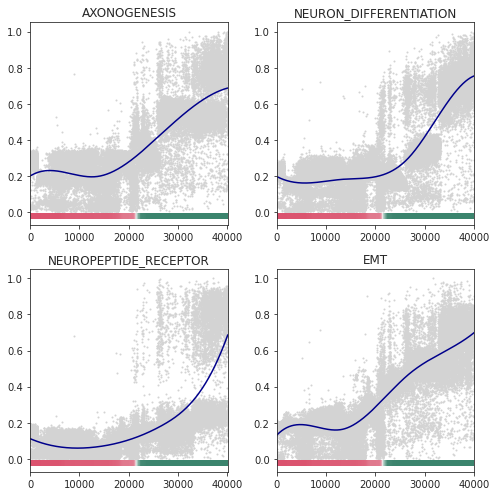

In [37]:
fig, axes = plt.subplots(2,2,figsize=(7,7))

for gset, ax in zip(gsets_interest, np.ravel(axes)):

    ax.scatter(pdt2.loc[::-1], gset_df[gset], s=1, c = 'lightgray')
    ax.plot(gamx['EMT'][::-1], gamy[gset], c='darkblue')
    ax.set_xlim([min(pdt2),max(pdt2)])
    ax.set_title(gset)
    
    scatter = ax.scatter(x=pdt2.loc[::-1], y=[-0.02] * len(pdt2),
                             c = row_colors2, cmap = pal_GR, s=25, marker='s') #label = use_samples[i])

plt.tight_layout()

plt.savefig('/data/peer/chanj3/HTA.SCLC.010920/out.SCLC.SCLCtype_deg.SCLC_only.010920/figures/1d_plot.SCLC-A_vs_SCLC-N.pathways.publication.png',
           bbox_inches='tight', dpi=300)

### Figure 3C

In [27]:
adata.obs.loc[:,'recurrent_cluster'] = adata.obs.clusters.astype(int)==22
adata.obs.loc[:,'recurrent_cluster'] = adata.obs.loc[:,'recurrent_cluster'].astype('category')

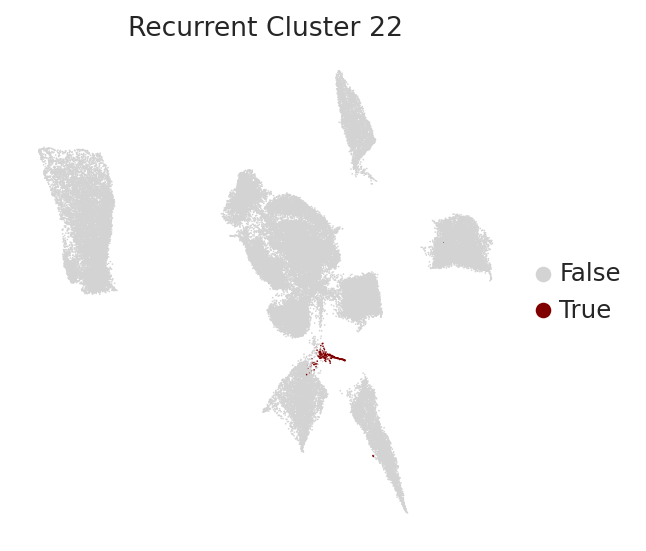

In [28]:
sc.pl.umap(adata, 
           color=['recurrent_cluster'],
    palette= ['lightgray', 'maroon'],
    frameon=False,  use_raw=False,
    sort_order=False, 
    ncols=1, title ='Recurrent Cluster 22',
)

### Figure 3G

In [22]:
adata.obs.tissue = adata.obs.tissue.str.replace('LN','Lymph_Node').str.replace('_','\n').str.replace('\nkidney','')
adata.obs.tissue = adata.obs.tissue.str.capitalize()

In [23]:
cat_order = pd.Series(np.ravel(adata.layers['imputed_normalized'][:,adata.var_names=='PLCG2']),
         index = adata.obs.index).groupby(adata.obs.tissue).median().sort_values().index.tolist()

In [24]:
adata.obs.loc[:,'Tissue'] = adata.obs.tissue.astype('category').cat.reorder_categories(cat_order)

... storing 'tissue' as categorical
/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


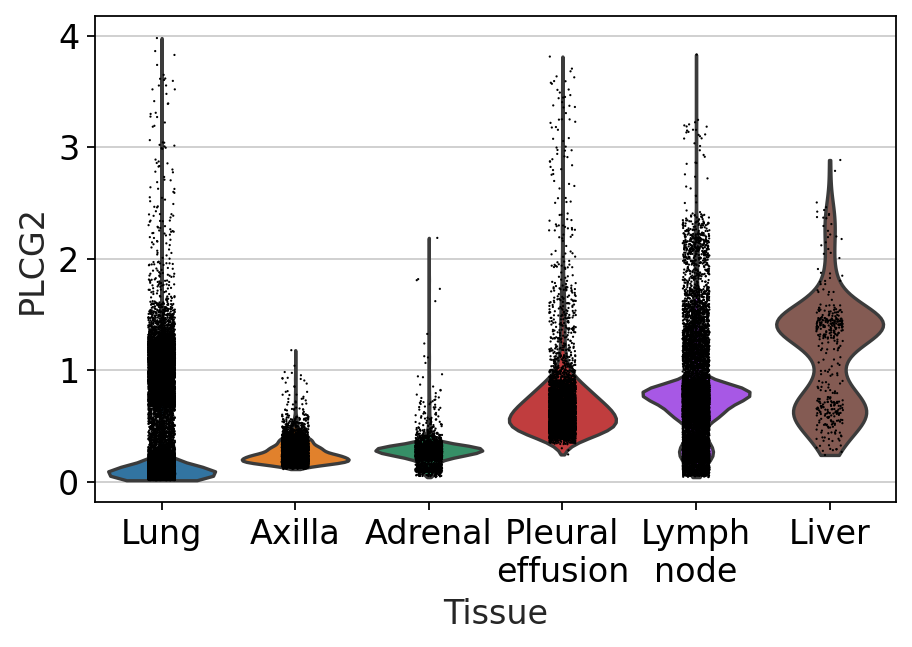

In [55]:
sc.set_figure_params(fontsize = 15, figsize = (6,4))
ax = sc.pl.violin(adata, ['PLCG2'], groupby='Tissue', 
                  layer = 'imputed_normalized',
                  dendrogram=False, use_raw = False)


In [20]:
PLCG2_tissue = {i:j for i,j in pd.Series(np.ravel(adata.X[:,adata.var_names=='PLCG2']),
                        index = adata.obs.index).groupby(adata.obs.Tissue)}

In [21]:
import scipy.stats as ss

In [26]:
{i: ss.ranksums(PLCG2_tissue['Lung'], PLCG2_tissue[i])[1]*(len(PLCG2_tissue)-1) for i in PLCG2_tissue.keys() if i!='Lung'}

{'Axilla': 1.0662131752927843e-23,
 'Adrenal': 0.018263864035680887,
 'Pleural\neffusion': 1.9878818851283695e-173,
 'Lymph\nnode': 0.0,
 'Liver': 3.787030503031331e-43}

### Figure S1G

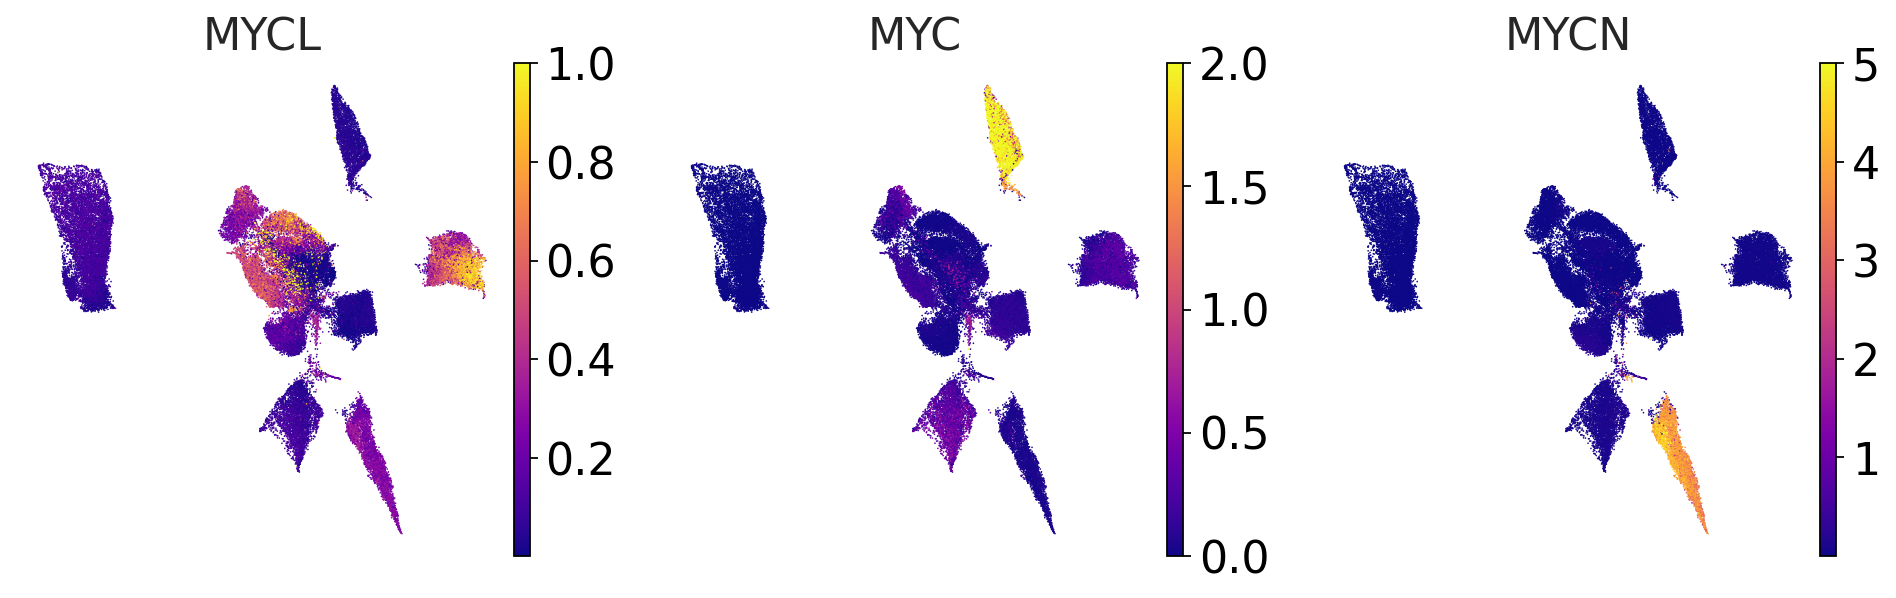

In [27]:
sc.pl.umap(adata, 
           color=['MYCL','MYC','MYCN'],
           color_map = 'plasma',
    frameon=False,  use_raw=False,
    sort_order=False, layer = 'imputed_normalized',
    ncols=3, vmax= [1,2,5]
)

### Figure S2B

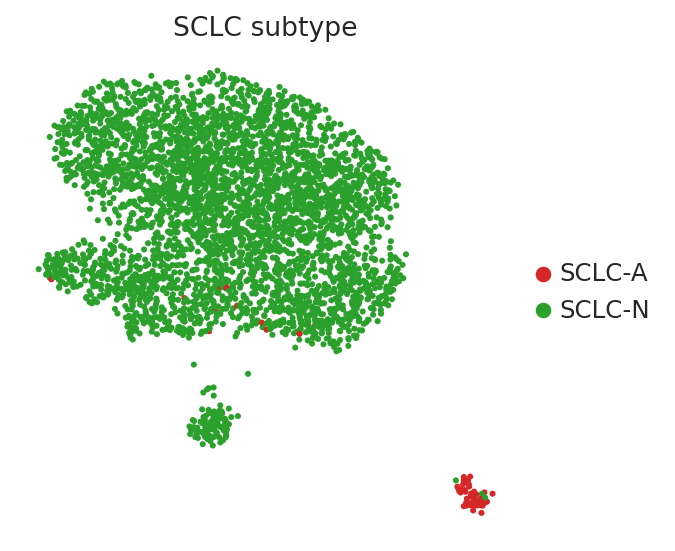

In [35]:
sc.pl.umap(
    adata_RU1215,
    color= ['SCLC subtype'],
    palette = ['tab:red','tab:green'],
    ncols=2, size=30,
    cmap='Spectral_r',
    legend_fontoutline=5, vmax = 5,
    frameon=False,
)

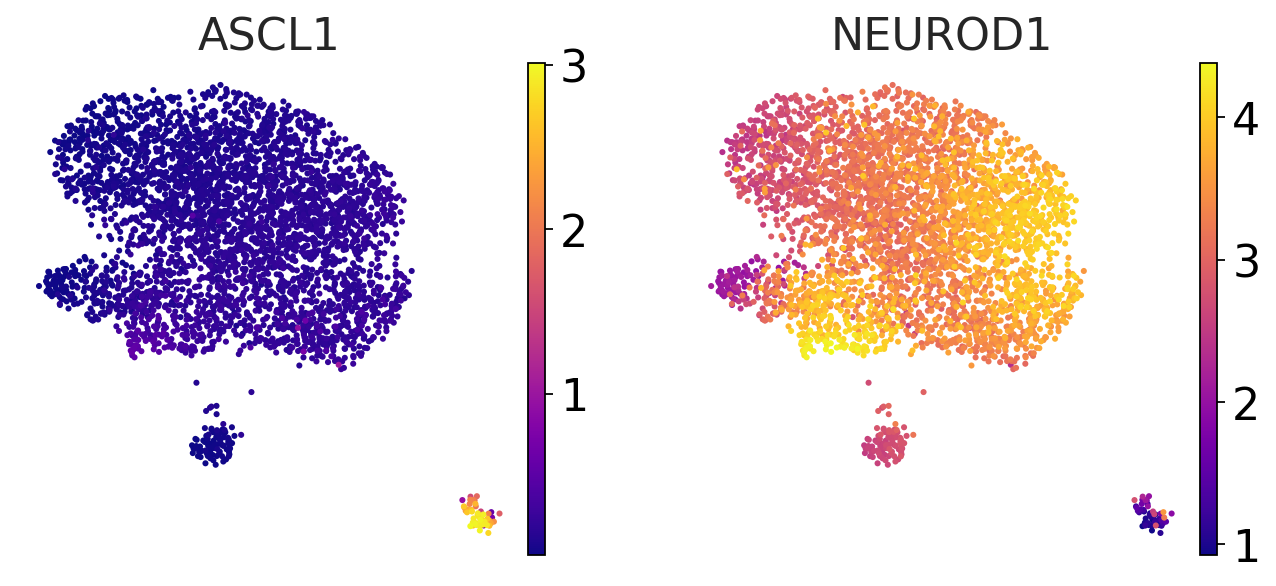

In [10]:
sc.pl.umap(
    adata_RU1215,
    color= ['ASCL1','NEUROD1'],
    ncols=2, size=30,
    cmap='plasma',
    legend_fontoutline=5, #vmax = 18,
    frameon=False, layer = 'imputed_normalized', 
)

<h3> Figure S3A </h3>

In [31]:
sc.set_figure_params(fontsize=15, dpi_save=300)
sc.settings.figdir = fig_dir

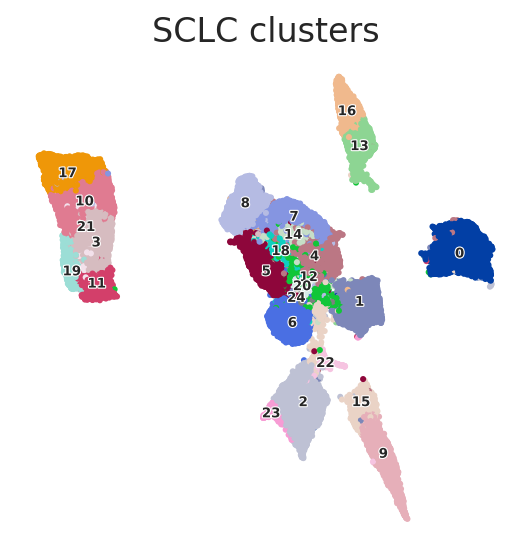

In [33]:
sc.pl.umap(
    adata,
    color= ['clusters'],
    ncols=2, size=30, legend_loc = 'on data',
    legend_fontoutline=1, legend_fontsize=6, #vmax = 18,
    frameon=False, title = 'SCLC clusters', save='.SCLC.clusters.png'
)

### Figure S3C

In [26]:
ccle = pd.read_csv(out_dir + 'bulk_ref/CCLE.microarray.exp.csv', sep = ',', index_col = 0).T
ccle_ct = pd.read_csv(out_dir + 'bulk_ref/CCLE.microarray.cell_type.csv', sep = '\t', index_col = 0, header = None)
ccle = ccle[ccle_ct.index=='SCLC']

In [27]:
# Subtype identification for ccle datasets
bulka = pd.read_csv(out_dir + 'bulk_ref/George_etal.limma.DEG.SCLC-A.090219.csv', sep = '\t', index_col = 0)
bulkn = pd.read_csv(out_dir + 'bulk_ref/George_etal.limma.DEG.SCLC-N.090219.csv', sep = '\t', index_col = 0)
bulkp = pd.read_csv(out_dir + 'bulk_ref/George_etal.limma.DEG.SCLC-P.090219.csv', sep = '\t', index_col = 0)
bulky = pd.read_csv(out_dir + 'bulk_ref/George_etal.limma.DEG.SCLC-Y.090219.csv', sep = '\t', index_col = 0)
bulka = bulka[(bulka['logFC']>10) & (bulka['AveExpr']>50) & (bulka['adj.P.Val']<0.01)].index
bulkn = bulkn[(bulkn['logFC']>10) & (bulkn['AveExpr']>50) & (bulkn['adj.P.Val']<0.01)].index
bulkp = bulkp[(bulkp['logFC']>10) & (bulkp['AveExpr']>50) & (bulkp['adj.P.Val']<0.01)].index
bulky = bulky[(bulky['logFC']>10) & (bulky['AveExpr']>50) & (bulky['adj.P.Val']<0.01)].index
scorea = zscore(ccle[bulka.intersection(ccle.columns)]).sum(1)
scoren = zscore(ccle[bulkn.intersection(ccle.columns)]).sum(1)
scorep = zscore(ccle[bulkp.intersection(ccle.columns)]).sum(1)
scorey = zscore(ccle[bulky.intersection(ccle.columns)]).sum(1)
score = pd.DataFrame([scorea, scoren, scorep, scorey]).T
score.index = ccle.index
score.columns = ['A','N','P','Y']

ccle_subtype = score.idxmax(1)


In [28]:
# Restrict to subtypes A and N only for consistency with scRNA-seq analysis.
ccle = ccle[ccle_subtype.isin(['A','N'])]

In [29]:
def get_scores(data, geneset1, geneset2):
    genes1 = set(geneset1).intersection(data.columns)
    genes2 = set(geneset2).intersection(data.columns)
    print('Number of genes in gene set1: {}'.format(len(genes1)))
    print('Number of genes in gene set2: {}'.format(len(genes2)))
    temp1 = data.loc[:,genes1]
    temp2 = data.loc[:,genes2]
    score1 = zscore(np.log2(temp1+1)).sum(1)
    score2 = zscore(np.log2(temp2+1)).sum(1)
    print(genes1.intersection(genes2))
    return score1, score2

In [31]:
gsea_plcg2 = pd.read_csv(out_dir + 'GSEA/GSEA.cluster22_vs_rest.filtered.csv',sep = '\t', index_col = 0)
gs_plcg2 = pd.read_csv(out_dir + 'MAST/DEG.recurrent_subpopulations.comb_pval.final.txt',sep = '\t', index_col = 0)


In [32]:
pathways = ['SENESE_HDAC1_TARGETS_UP','LIAO_METASTASIS','MILI_PSEUDOPODIA_CHEMOTAXIS_DN',
'MARTORIATI_MDM4_TARGETS_FETAL_LIVER_DN','SENESE_HDAC3_TARGETS_UP','GRESHOCK_CANCER_COPY_NUMBER_UP',
'HALLMARK_MITOTIC_SPINDLE','ZHANG_TLX_TARGETS_36HR_DN','CHANDRAN_METASTASIS_UP']

In [33]:
from scipy.stats import spearmanr
cor_list = []
pval_list = []
for gs in pathways:
    geneset2 = gsea_plcg2.loc[gs]['leadingEdge'].split(',')
    geneset1 = gs_plcg2.index
    geneset2 = list(set(geneset2).difference(set(geneset2).intersection(set(geneset1))))

    score1, score2 = get_scores(ccle, geneset1, geneset2)
    cor = spearmanr(score1, score2).correlation
    pval = spearmanr(score1, score2).pvalue
    
    cor_list.append(cor)
    pval_list.append(pval)
    

Number of genes in gene set1: 38
Number of genes in gene set2: 196
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 220
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 174
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 232
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 234
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 150
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 100
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 96
set()
Number of genes in gene set1: 38
Number of genes in gene set2: 84
set()


In [34]:
order = np.argsort(np.array(cor_list))

Text(0.5, 0, 'Correlation with Recurrent Cluster Signature')

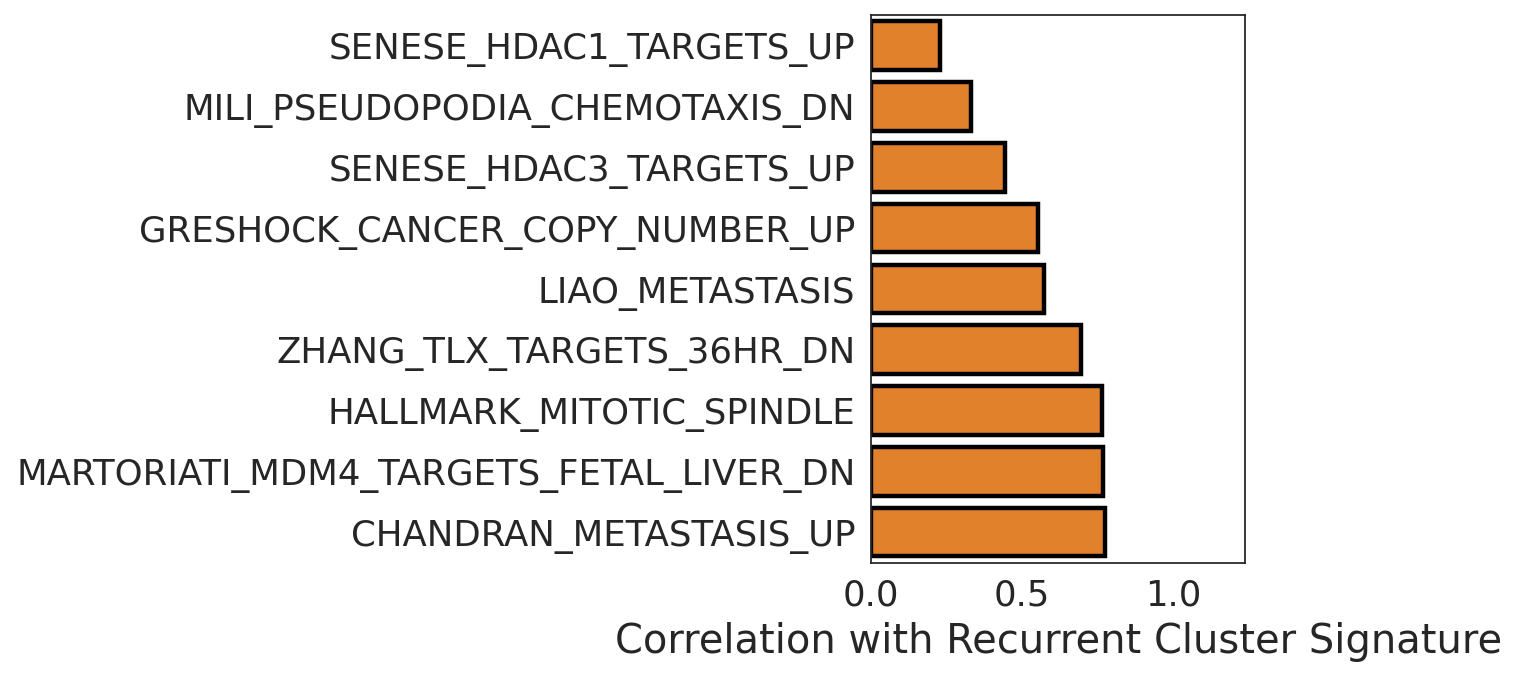

In [35]:
sns.set_style(style='white')
plt.rcParams['figure.figsize'] = [3,4.5]
ax = sns.barplot(y = np.arange(9), x = np.array(cor_list)[order],orient='horizontal', color = 'tab:orange', edgecolor = 'black')
plt.yticks(np.arange(9), np.array(['SENESE_HDAC1_TARGETS_UP','LIAO_METASTASIS','MILI_PSEUDOPODIA_CHEMOTAXIS_DN',
'MARTORIATI_MDM4_TARGETS_FETAL_LIVER_DN','SENESE_HDAC3_TARGETS_UP','GRESHOCK_CANCER_COPY_NUMBER_UP',
'HALLMARK_MITOTIC_SPINDLE','ZHANG_TLX_TARGETS_36HR_DN','CHANDRAN_METASTASIS_UP'])[order], fontsize=16)
plt.setp(ax.patches, linewidth=2)
plt.xticks(fontsize = 16)
plt.xlim(0,1.24)
plt.xlabel('Correlation with Recurrent Cluster Signature', fontsize = 18)


In [36]:
pd.Series(pval_list, index = pathways)

SENESE_HDAC1_TARGETS_UP                   1.919969e-01
LIAO_METASTASIS                           4.102406e-04
MILI_PSEUDOPODIA_CHEMOTAXIS_DN            5.578489e-02
MARTORIATI_MDM4_TARGETS_FETAL_LIVER_DN    1.060024e-07
SENESE_HDAC3_TARGETS_UP                   8.501015e-03
GRESHOCK_CANCER_COPY_NUMBER_UP            6.726587e-04
HALLMARK_MITOTIC_SPINDLE                  1.375195e-07
ZHANG_TLX_TARGETS_36HR_DN                 4.879574e-06
CHANDRAN_METASTASIS_UP                    7.237650e-08
dtype: float64

### Figure S3D

Text(0.5, 0, 'Log library size')

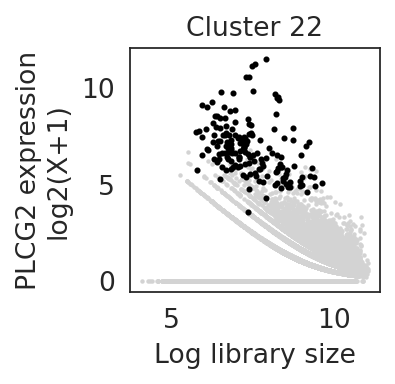

In [37]:
fig, ax = plt.subplots(1,1,figsize = (2,2))

i=22
ind = adata.obs.clusters==i
ax.scatter(adata.obs.log1p_total_counts, adata.X[:,adata.var_names=='PLCG2'], s=1, c='lightgray')
ax.scatter(adata.obs.loc[ind,'log1p_total_counts'], adata.X[ind,adata.var_names=='PLCG2'], c='black', s=3)
ax.set_title('Cluster %d' % i)

ax.set_ylabel('PLCG2 expression\nlog2(X+1)')
ax.set_xlabel('Log library size')


### Figure S3E

In [38]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

In [39]:
#thr = dremi_dn_df.mean().iloc[0] + 2.5*dremi_dn_df.std().iloc[0] 
thr = 0.985

In [40]:
dremi_dn_df = adata.var.loc[:,'knnDREMI|PLCG2'].sort_values()

In [41]:
imp_merge = pd.DataFrame(adata.layers['imputed_normalized'],
                         index=adata.obs.index,
                         columns = adata.var_names)

In [155]:
genes = dremi_dn_df.index[dremi_dn_df > thr ]

In [157]:
mat = imp_merge.loc[:,genes.tolist()].sort_values('PLCG2').T



In [159]:
pal = ['tab:red','tab:green','tab:blue']
lut = dict(zip(['SCLC-A','SCLC-N','SCLC-P'], pal))
col_SCLCtype = adata.obs.SCLC_subtype.astype(str).map(lut)
col_SCLCtype.name = 'SCLC subtype' 


In [194]:
modules = adata.var.loc[mat.index,'PLCG2_modules'].astype(str).astype(str)

In [216]:
pal = ['tab:purple','tab:gray','tab:orange']
lut = dict(zip(['1: PLCG2-low','2: PLCG2-medium','3: PLCG2-high'], pal))
row_clust = modules.map(lut)


In [217]:
plcg2 = mat.loc['PLCG2',:]
plcg2 = (plcg2 - plcg2.mean())/plcg2.std()
span = 2 #max(np.abs(plcg2))
bins = np.linspace(-span, span, 100)
plcg2 = pd.Series(np.digitize(plcg2, bins), index = plcg2.index)
pal = sns.color_palette('bwr',101)
lut = dict(zip(np.arange(101), pal))
col_plcg2 = plcg2.map(lut)
col_plcg2.name = 'PLCG2'

In [218]:
n_convolve = 100
weights = np.ones(n_convolve) / n_convolve
mat2 = deepcopy(mat)
for gene in mat2.index:
    mat2.loc[gene,:] = np.convolve(mat2.loc[gene].values, weights, mode="same")


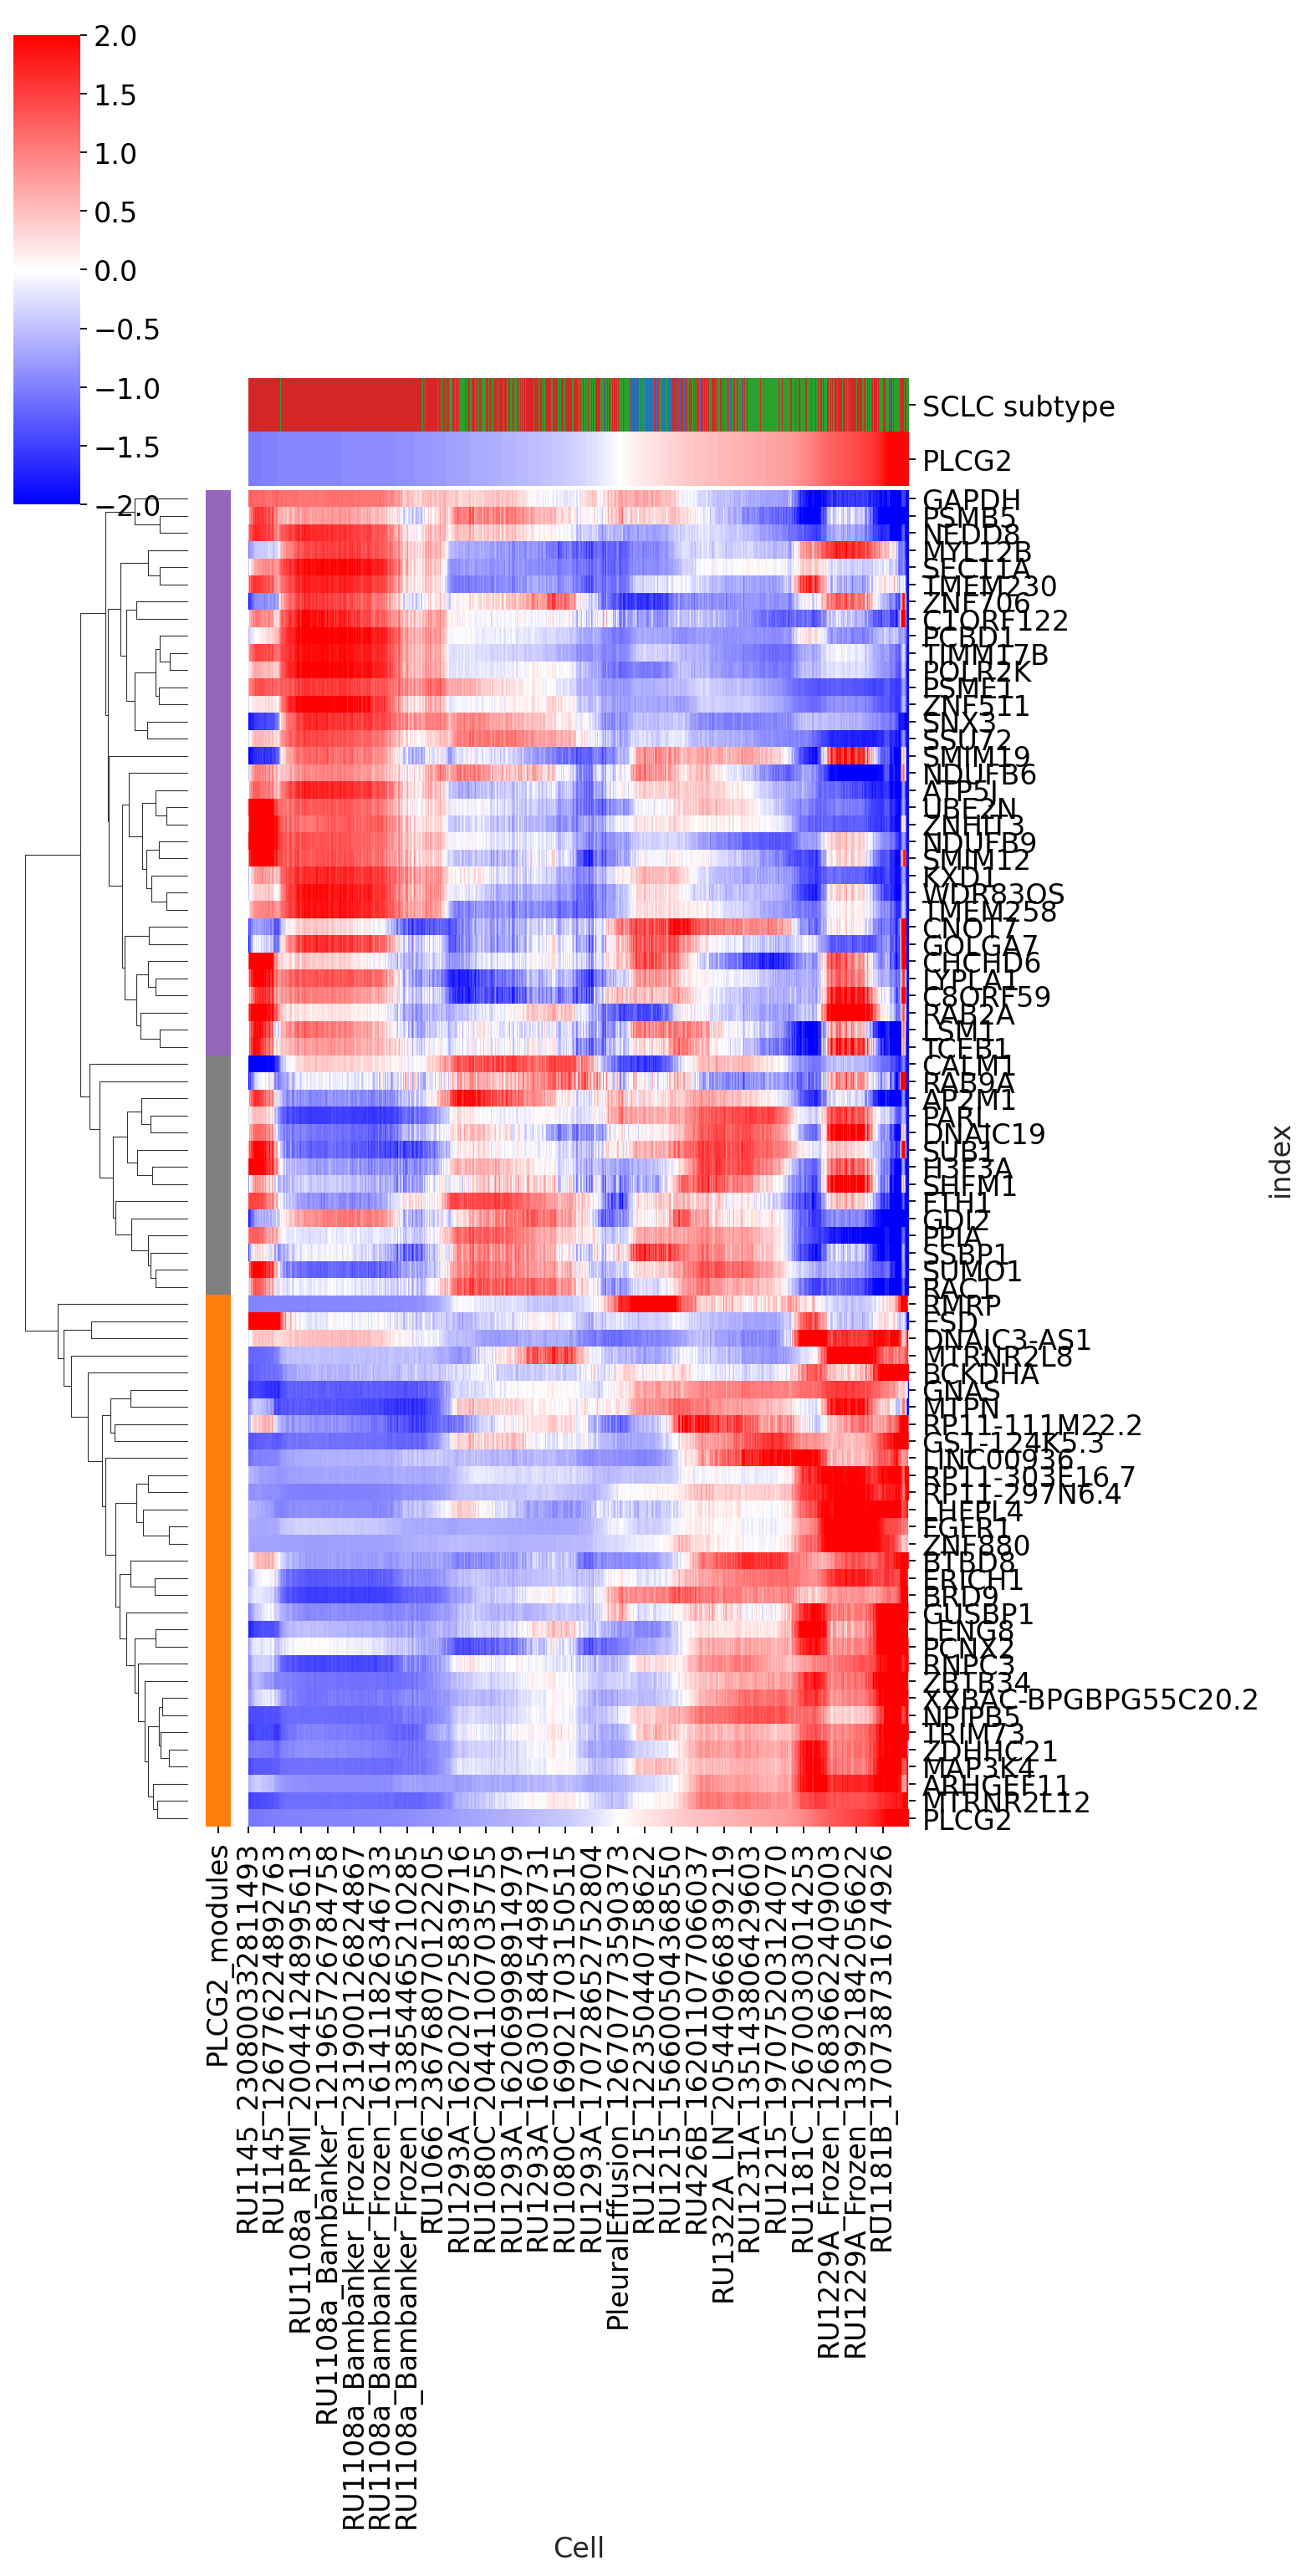

In [219]:
cm3 = sns.clustermap(mat2, row_cluster = True, col_cluster = False,z_score=0,figsize = (10,19.5),
              cmap = plt.cm.bwr, center=0, vmin=-2, vmax=2,
                     metric = 'correlation',
                     col_colors = pd.concat([col_SCLCtype, col_plcg2],axis=1),
                     row_colors = row_clust, yticklabels = True,
                     row_linkage = cm.dendrogram_row.linkage)
